# AOS DM-34424 : rotate M1 surface Grid

Ticket : https://jira.lsstcorp.org/browse/DM-34424

Create a random surface. Plot the un-rotated surface grid and a rotated surface grid. Simulate with phoSim and recover Zks. Compare.

# 1) Plot a random surface and rotate it

In [1]:
import os
import sys
sys.path.append('/project/scichris/aos/')
import analysisTools as at
import importlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np







/tmp/ipykernel_2804023/2134268914.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
from lsst.ts.phosim.telescope.M1M3Sim import M1M3Sim

m1m3 = M1M3Sim()

#xgrid, ygrid = at.get_xy_from_yaml(get_actuators=False)
nodeM1, nodeM3, bx, by, bz = m1m3._getMirCoor() # use m1m3 built in function to get the zemax grid... 
xgrid, ygrid = bx, by 


In [28]:
at.get_xy_from_yaml??


In [5]:
randSurfInM = m1m3.genMirSurfRandErr(zAngleInRadian=0)

In [6]:
randSurfInM1 = m1m3.genMirSurfRandErr(zAngleInRadian=0)

In [7]:
randSurfInM

array([ 1.36372314e-06, -4.58606574e-07, -1.36072064e-06, ...,
        2.73532254e-07,  2.11360075e-07,  9.58190834e-08])

In [10]:
np.sum(randSurfInM-randSurfInM1)

0.0

They're identcal, probably precisely because of the simulation seed:

In [11]:
m1m3.genMirSurfRandErr?

In [15]:
data = m1m3._gridFile.getMatContent()

In [17]:
np.shape(data)

(5256, 159)

In [24]:
for row in data[:5]:
    print(row[0],row[1], row[2])

1.0 1.125995 4.018737
1.0 4.043326 1.034229
1.0 4.043326 -1.03423
1.0 2.917331 -2.98451
1.0 1.125995 -4.01874


In [26]:
x = data[:,1]
y = data[:,2]

array([ 1.125995,  4.043326,  4.043326, ..., -0.475801, -0.497489,
       -0.021687])

So the function `_getMirCoor` already returns that, calling it `bx,by,bz`...



In [29]:
nodeM1, nodeM3, bx, by, bz = m1m3._getMirCoor()

In [31]:
len(bx)

5256

In [20]:
at.get_xy_from_yaml??

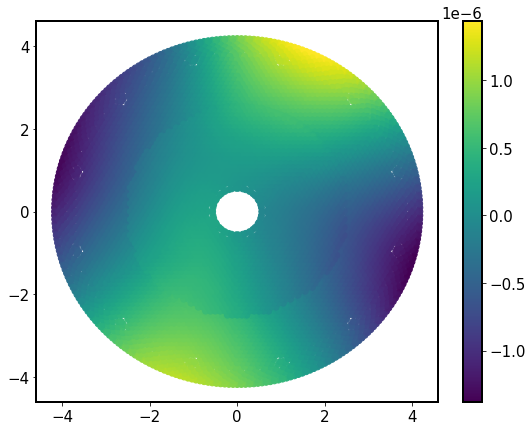

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
randSurfInM = m1m3.genMirSurfRandErr(zAngleInRadian=0)
fig,ax  = plt.subplots(1,1,figsize=(9,7))
plt.scatter(xgrid, ygrid, c=randSurfInM)
plt.colorbar()

In [29]:
def DoRotation(xspan, yspan, RotRad=0):
    """Generate a meshgrid and rotate it by RotRad radians."""

    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(RotRad),  np.sin(RotRad)],
                          [-np.sin(RotRad), np.cos(RotRad)]])

    x, y = np.meshgrid(xspan, yspan)
    return np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([x, y]))


In [34]:
np.shape(x)

(5256,)

According to the rotation matrix:

$\begin{equation*}
\begin{bmatrix}
x' \\
y'
\end{bmatrix}
= 
\begin{bmatrix}
\cos{(\theta)} & -sin{(\theta)} \\
sin{(\theta)}  & \cos{(\theta)} \\
\end{bmatrix}
\begin{bmatrix}
x \\
y
\end{bmatrix}
\end{equation*}$

We rotate each (x,y) pair of coordinates:

In [4]:
def rot_mat(rot):
    """Return rotation matrix.
    Parameters
    ----------
    rot : `float`
        Rotation angle in degrees.
    """
    rot_rad = np.deg2rad(rot)
    c, s = np.cos(rot_rad), np.sin(rot_rad)
    return np.array(((c, -s), (s, c)))

def rotate_xy(x,y,angleInDeg):
    xrot=np.zeros_like(x)
    yrot=np.zeros_like(y)
    for i in range(len(x)):
        xy = np.array([x[i],y[i]])
        #print(xy)
        xyrot = rot_mat(angleInDeg).dot(xy)
        xrot[i] = xyrot[0]
        yrot[i] = xyrot[1]

    return xrot,yrot

Show that the 10 degree rotation worked:

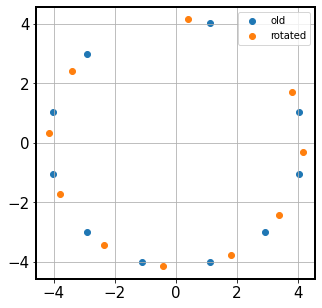

In [5]:
xrot,yrot = rotate_xy(x,y,10)
fig = plt.figure(figsize=(5,5))
plt.scatter(x[:10],y[:10], label='old')
plt.scatter(xrot[:10],yrot[:10], label='rotated')
plt.grid()
plt.legend()

Rotate by 30 degrees, plot the original grid, rotated grid (x,y grid location shifts and the z-values are carried with them so they do not change), and the regridded z-values onto the original grid (the z-values change to match the original grid locations). 

All regridding is done with https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html?highlight=griddata . The example I found that uses `RectBivariateSpline` would only work if the data is gridded already on a 2D regular grid (which it isn't). So `griddata` is perfect for my need (regrid non-uniform irregular grid onto another irregular grid). 

Text(0.5, 1.0, 'regridded surface')

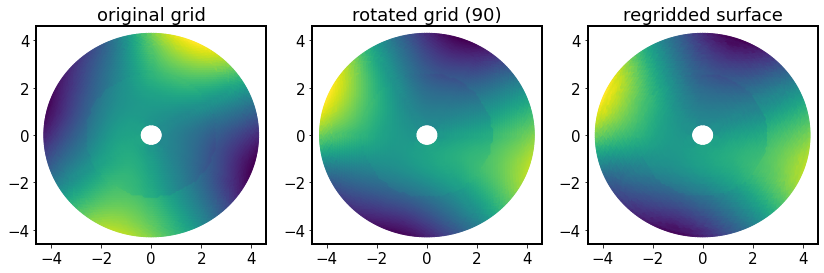

In [7]:
from scipy.interpolate import griddata

fig,ax = plt.subplots(1,3,figsize=(14,4))
deg = 90
xrot,yrot = rotate_xy(xgrid,ygrid,deg)
zval = randSurfInM
ax[0].scatter(xgrid,ygrid,c=zval)
ax[0].set_title('original grid')
ax[1].scatter(xrot,yrot,c=zval)
ax[1].set_title(f'rotated grid ({deg})')
# regrid the rotated coords so that the surface is rotated, but not the coordinates...

# griddata( N of (x,y), and list of N z-values, 
#                    --> M values of 
#                    (xnew, ynew) for which M of regrid_val will be calculated)
regrid_zval = griddata((xrot, yrot), zval, (xgrid, ygrid), method='nearest')
ax[2].scatter(xgrid, ygrid, c=regrid_zval)
ax[2].set_title('regridded surface')
#ax[1].scatter(x[:N],y[:N],c=randSurfInM[:N])

#ax[1].scatter(x,y,c=np.roll(randSurfInM,100))

## [Aside]: 

This does rotate correctly; the only problem is that instead of rotating the `randSurfInM`, I rotated the underlying x,y grid positions. In reality, x,y grid positions do not change. So how can we rotate the z-surface?

   Try to use the solution from https://stackoverflow.com/questions/50881318/regrid-2d-data-onto-larger-2d-grid-at-given-coordinates-in-python, which involves regridding. That's what it really is - I have an image `z` in coords `xrot`, `yrot`, and want to put it back into `x`, `y`. This will provide `zregrid` values on the old grid. The only problem with that solution is that it required `x`,`y` to be uniform and `z` to be  a 2D array. In my case, it was better to use `interpolate.griddata` which allows for irregular data samples. 

# 2) Implement rotation into the simulation; simulate just one time 



First, run the loop without any modifications. Then run with adding the rotation. Check that the actual unrotated surface is the same each time (I think it is because the simulation seed is the same for repeatability, but compare the surfaces just to be sure). 

    cd /project/scichris/aos/ts_phosim
    git checkout develop
    git pull
    git checkout -b tickets/DM-34424


    cp ../rotation_DM-31532/runSlurm0_c.sl .
    
    edited that to contain 
    
    
    python /project/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst comcam --iterNum  1 --numOfProc 55 --boresightDeg 0.0 0.0  --rotCam 0 --skyFile /project/scichris/aos/rotation_DM-34065/singleStarBoresight00.txt  --output /project/scichris/aos/rotation_DM-34424/rot_0/


once this is done, make the edit in `M1M3Sim.py`, adding at the end of  https://github.com/lsst-ts/ts_phosim/blob/2d3ab7a18d5ba89c719a232a4beba19f8443724e/python/lsst/ts/phosim/telescope/M1M3Sim.py#L631 




The mirror surface is used in `TeleFacade.py` here https://github.com/lsst-ts/ts_phosim/blob/4172fa9eb23b30ef4b85684cc3d6ddf188cc9f55/python/lsst/ts/phosim/telescope/TeleFacade.py#L836 to create a pert.cmd file, that is then used to create an inst file. 

I submit `runSlurm30.sl ` , which has basically the same args passed to `imgCloseLoop` as above. 

In [ ]:
from scipy.interpolate import griddata
def rot_mat(rot):
    """Return rotation matrix.
    Parameters
    ----------
    rot : `float`
        Rotation angle in degrees.
    """
    rot_rad = np.deg2rad(rot)
    c, s = np.cos(rot_rad), np.sin(rot_rad)
    return np.array(((c, -s), (s, c)))

def rotate_xy(x,y,angleInDeg):
    xrot=np.zeros_like(x)
    yrot=np.zeros_like(y)
    for i in range(len(x)):
        xy = np.array([x[i],y[i]])
        xyrot = rot_mat(angleInDeg).dot(xy)
        xrot[i] = xyrot[0]
        yrot[i] = xyrot[1]

    return xrot,yrot


nodeM1, nodeM3, bx, by, bz = m1m3._getMirCoor() 
xgrid, ygrid = bx, by
zval = randSurfInM
xrot,yrot = rotate_xy(xgrid,ygrid,30)
regrid_zval = griddata((xrot, yrot), zval, (xgrid, ygrid), method='nearest')

{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123106001}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


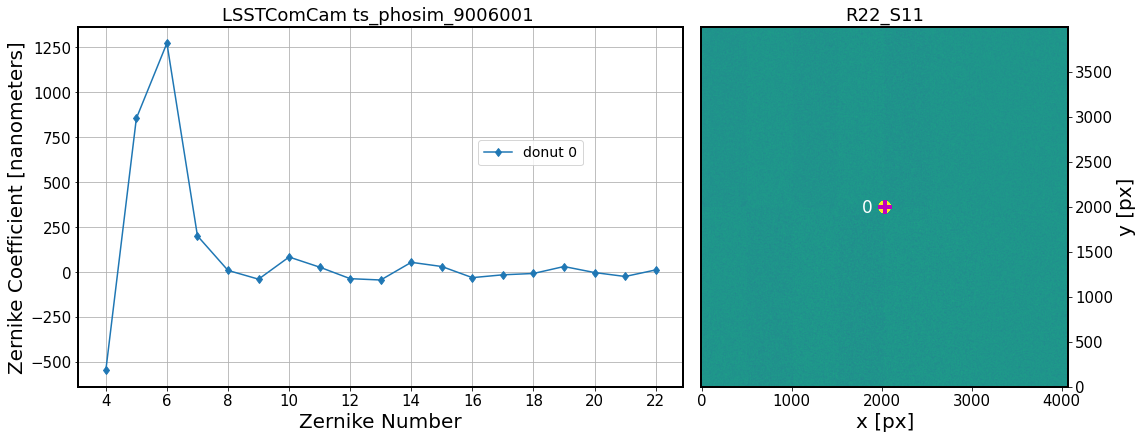

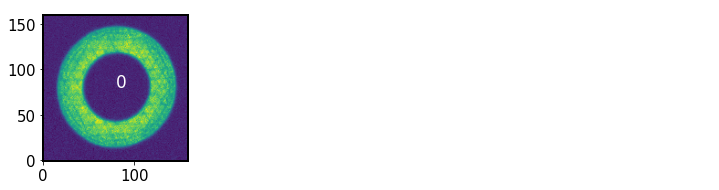

In [21]:
data_dir = '/project/scichris/aos/rotation_DM-34424/rot_0/'
iterN = 0
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',)
                   #titleAdd= 'rotCam=rotSkyPos=0, ')



{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123106001}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


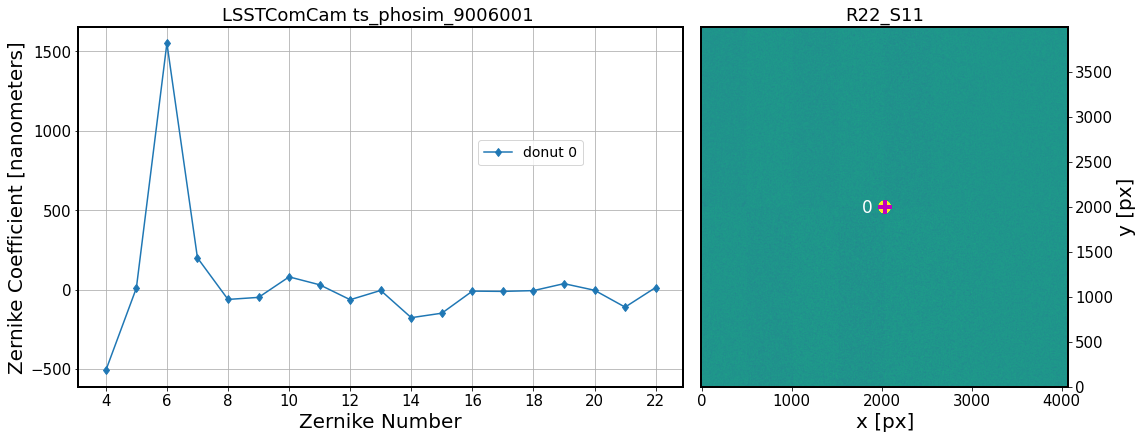

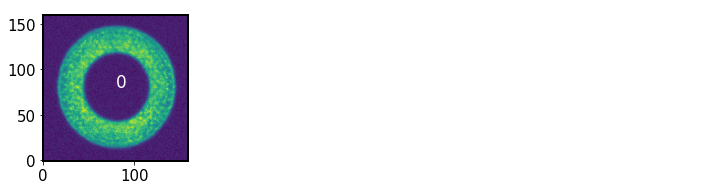

In [22]:
data_dir = '/project/scichris/aos/rotation_DM-34424/rot_30/'
iterN = 0
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',)
                   #titleAdd= 'rotCam=rotSkyPos=0, ')



{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123106001}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


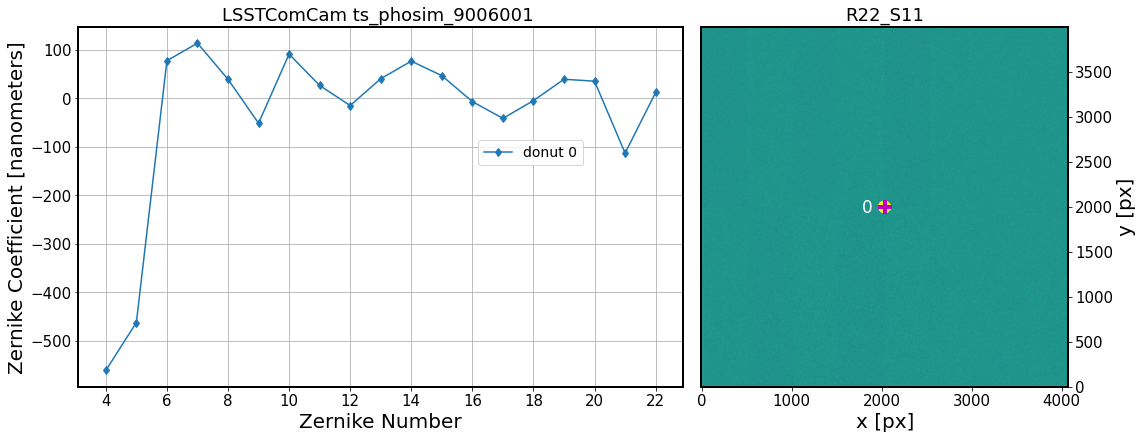

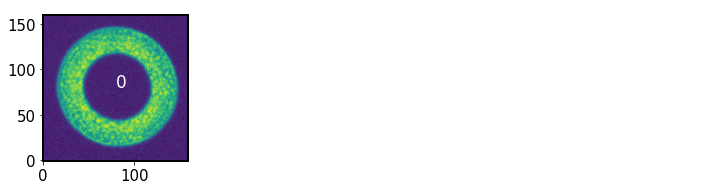

In [23]:
%matplotlib inline
data_dir = '/project/scichris/aos/rotation_DM-34424/rot_90/'
iterN = 0
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',)
#                   titleAdd= 'rotCam=rotSkyPos=0, ')



In [5]:
from lsst.daf import butler as dafButler
zkRaws = {}
donutStamps={}
for rot in [0,30,90]:
    data_dir = f'/project/scichris/aos/rotation_DM-34424/rot_{rot}/'
    repoDir = os.path.join(data_dir, 'phosimData')
    collection=f'ts_phosim_90060{iterN}1'
    instrument='LSSTComCam'
    detector='R22_S11'

    butler = dafButler.Butler(repoDir)
    registry = butler.registry

    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                        datasetType='postISRCCD',
                        dataId=dataId0, 
                        collections=[collection]  )))

    expN = dataset.dataId["exposure"]

    # construct a dataId for zernikes and donut catalog:
    # switch exposure to visit 
    dataId = {'detector':detector, 'instrument':instrument,
              'visit':expN}
    print(dataId)
    # the raw Zernikes 
    zkRaw =  butler.get('zernikeEstimateRaw', dataId=dataId,
                        collections=[collection])
    
    # the donuts
    extraFocalStamps = butler.get('donutStampsExtra', 
                              dataId=dataId, 
                              collections=[collection])
    
    zkRaws[rot] = zkRaw
    donutStamps[rot] = extraFocalStamps

{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


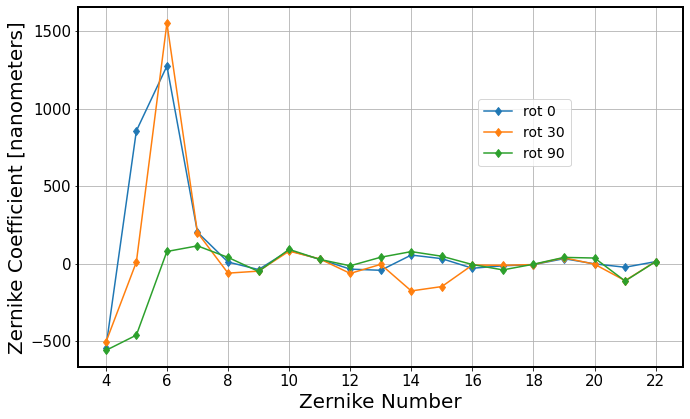

In [8]:
fig = plt.figure(figsize=(14, 5))

####################################
### left - plot the fit results  ###
#################################### 

#add_axes([xmin,ymin,dx,dy]) 
ax1 = fig.add_axes([0,0,0.6,1])  
for rot in zkRaws.keys():
    zkRaw = zkRaws[rot]
    for i in range(len(zkRaw)):
        ax1.plot(np.arange(4, 23),1000*zkRaw[i], 
                 '-d', label=f'rot {rot}')

ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.65, 0.65])
ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()

In [50]:
donutStamp = donutStamps[rot][0]

Text(0.5, 1.0, 'rot 0 - rot 30')

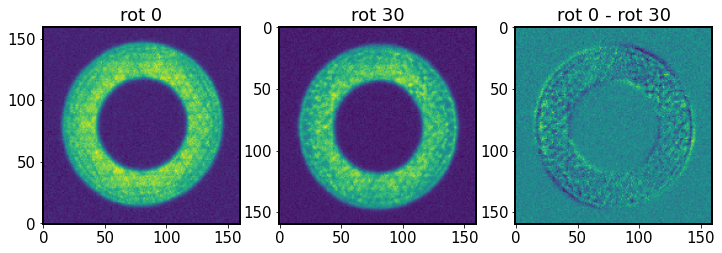

In [10]:
fig,ax = plt.subplots(1,3,figsize=(12,4))

donutStamp = donutStamps[0][0]
donut0 = donutStamp.stamp_im.image.array
ax[0].imshow(donut0, origin='lower')
ax[0].set_title('rot 0')
donutStamp = donutStamps[30][0]
donut30 = donutStamp.stamp_im.image.array

ax[1].imshow(donut30)
ax[1].set_title('rot 30')

ax[2].imshow(donut0-donut30)
ax[2].set_title('rot 0 - rot 30')

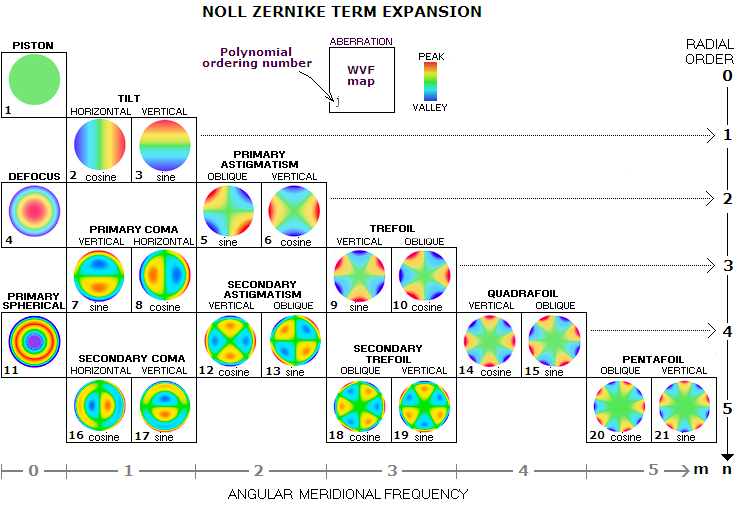

In [15]:
# primary astigmatism
Nstart=4
for rot in zkRaws.keys():
    zkRaw = zkRaws[rot][0]
    print(rot, 'zk5**2+zk6**2=',zkRaw[5-Nstart]**2.0+zkRaw[6-Nstart]**2.0)
    

0 zk5**2+zk6**2= 2.355095264778936
30 zk5**2+zk6**2= 2.4042893076362084
90 zk5**2+zk6**2= 0.2194074115507694


In [16]:
# primary coma 
Nstart=4
for rot in zkRaws.keys():
    zkRaw = zkRaws[rot][0]
    print(rot, 'zk7**2+zk8**2=',zkRaw[7-Nstart]**2.0+zkRaw[8-Nstart]**2.0)
    

0 zk7**2+zk8**2= 0.040799022979641573
30 zk7**2+zk8**2= 0.043676811743358836
90 zk7**2+zk8**2= 0.014523925265009221


In [17]:
# trefoil  9,10 
for rot in zkRaws.keys():
    zkRaw = zkRaws[rot][0]
    print('rot ', rot, 'zk9**2+zk10**2=',zkRaw[9-Nstart]**2.0+zkRaw[10-Nstart]**2.0)

0 zk9**2+zk10**2= 0.0086164605975037
30 zk9**2+zk10**2= 0.00878829454587453
90 zk9**2+zk10**2= 0.010969185357269541


In [18]:
# secondary astigmatism zk12-13
for rot in zkRaws.keys():
    zkRaw = zkRaws[rot][0]
    print('rot ', rot, 'zk12**2+zk13**2=',zkRaw[12-Nstart]**2.0+zkRaw[13-Nstart]**2.0)

rot  0 zk12**2+zk13**2= 0.003217143169167191
rot  30 zk12**2+zk13**2= 0.004107545901589935
rot  90 zk12**2+zk13**2= 0.0018599029037186705


In [19]:
# quadrafoil zk14-15
for rot in zkRaws.keys():
    zkRaw = zkRaws[rot][0]
    print('rot ', rot, 'zk14**2+zk15**2=',zkRaw[14-Nstart]**2.0+zkRaw[15-Nstart]**2.0)

rot  0 zk14**2+zk15**2= 0.00397740055794563
rot  30 zk14**2+zk15**2= 0.05338734548362414
rot  90 zk14**2+zk15**2= 0.008100732016136715


Check if between orthgonal zks, from 0 to 90 the values flip (?)

In [20]:
# 5-->6
print('rot 0, zk5 ', zkRaws[0][0][5-Nstart], '--> rot 90 zk6',  zkRaws[90][0][6-Nstart])

rot 0, zk5  0.8556848448086581 --> rot 90 zk6 0.07765953474643024


## Run only M1M3 (turn off M2 in `CloseLoopTask.py`)

Try running only M1M3 perturbations, without M2... To this end, perhaps the quickest way is to modify `CloseLoopTask.py`, and in line

    211        tele.addSubSys(addCam=True, addM1M3=True, addM2=True)

change to

    211        tele.addSubSys(addCam=True, addM1M3=True, addM2=False)

I make sure that I first run the `0` , with only `M1M3` perturbations. Then introduce rotation, but only of the surface. 

* `0` : has `CloseLoopTask.py` 
        
    211        tele.addSubSys(addCam=True, addM1M3=True, addM2=False)

and `M1M3Sim.py` 
    
    639        return randSurfInM   (i.e. returninig the original surface)


sbatch runSlurm0_m1m3.sl

* `30` has same `CloseLoopTask.py` as above:
        
    211        tele.addSubSys(addCam=True, addM1M3=True, addM2=False)

and `M1M3Sim.py`

    636    xrot, yrot = self.rotate_xy(xgrid, ygrid, 30)
    637    regrid_randSurfInM = griddata((xrot, yrot), randSurfInM, (xgrid, ygrid), method='nearest')
     
    639    #return randSurfInM
    640    return regrid_randSurfInM


* `90` has same `CloseLoopTask`, while in `M1M3Sim.py` it has 

    636    xrot, yrot = self.rotate_xy(xgrid, ygrid, 30)

## Show the results of running these tests only for `M1M3`: 

{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123106001}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


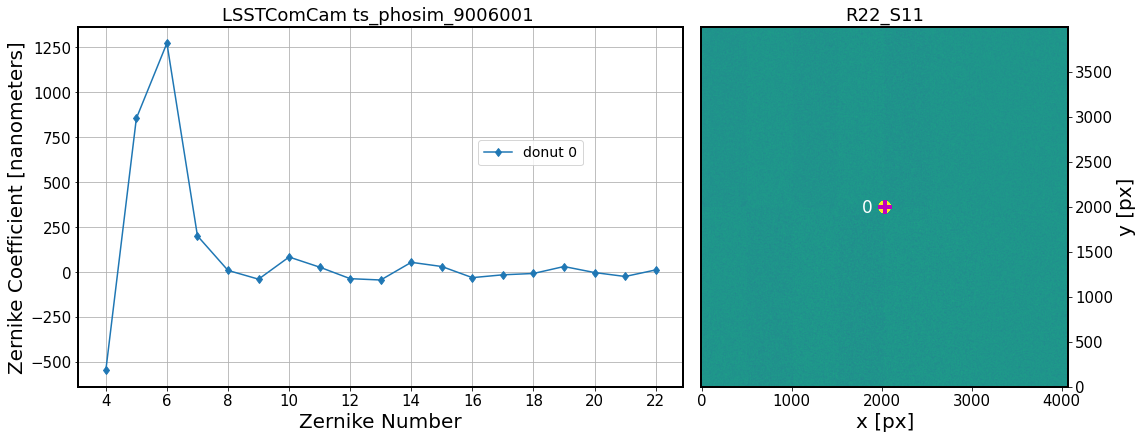

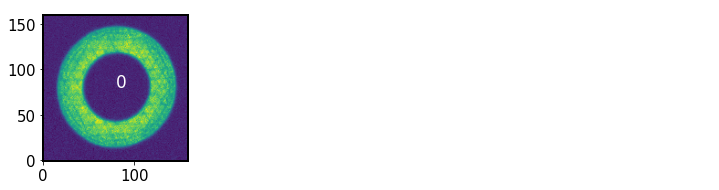

In [2]:
data_dir = '/project/scichris/aos/rotation_DM-34424/rot_0_m1m3/'
iterN = 0
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',)
                   #titleAdd= 'rotCam=rotSkyPos=0, ')



{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123106001}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


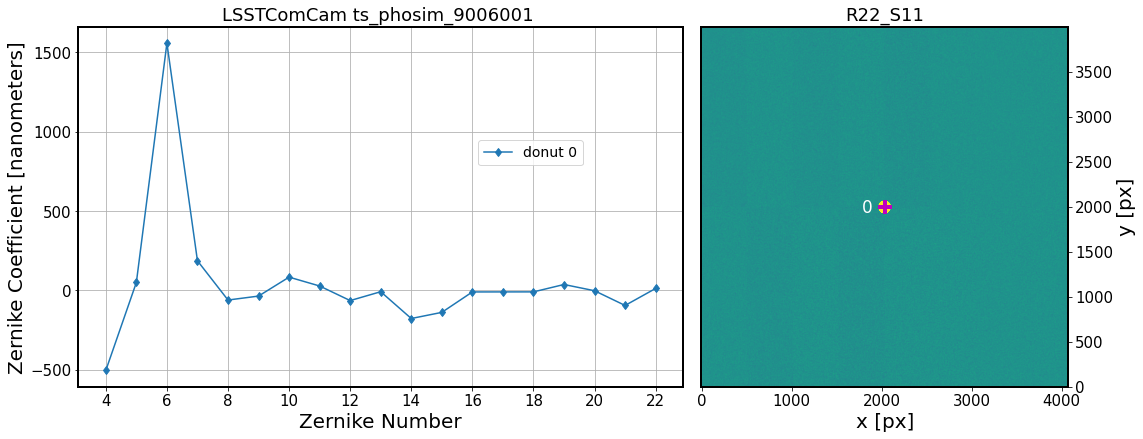

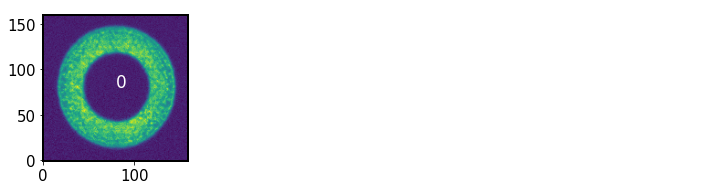

In [4]:
data_dir = '/project/scichris/aos/rotation_DM-34424/rot_30_m1m3/'
iterN = 0
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',)
                   #titleAdd= 'rotCam=rotSkyPos=0, ')



{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123106001}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


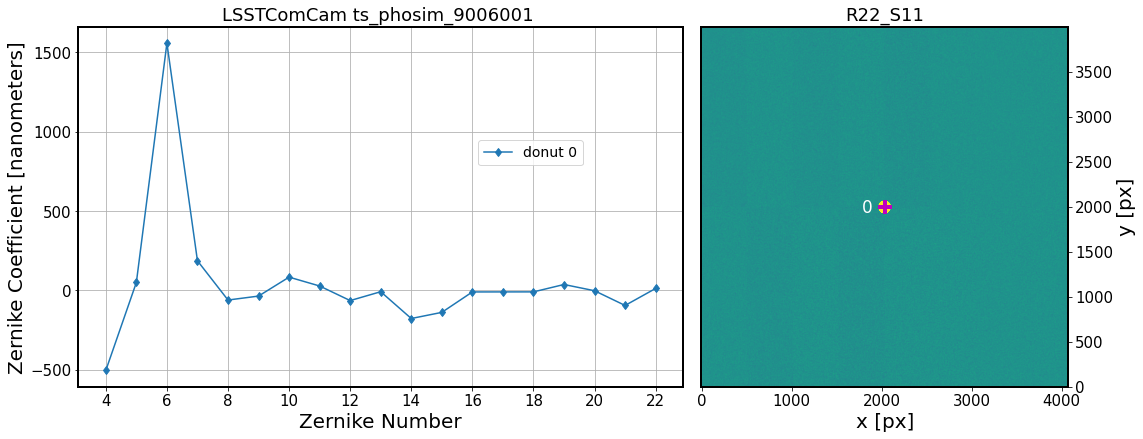

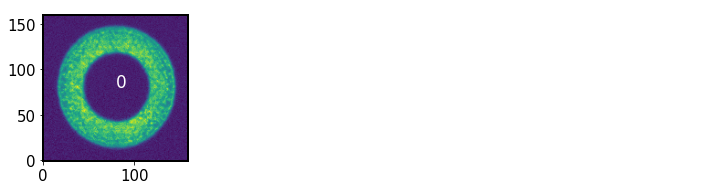

In [5]:
data_dir = '/project/scichris/aos/rotation_DM-34424/rot_90_m1m3/'
iterN = 0
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',)
                   #titleAdd= 'rotCam=rotSkyPos=0, ')



In [13]:
from lsst.daf import butler as dafButler
zkRaws = {}
donutStamps={}
for rot in [0,30,90]:
    zkRaws[rot]= {}
    donutStamps[rot] = {}

    for pert in ['M2_M1M3', 'M1M3']:
        if pert == 'M2_M1M3':
            suffix = ''
        elif pert =='M1M3':
            suffix = '_m1m3'
        print(pert, rot )    
        data_dir = f'/project/scichris/aos/rotation_DM-34424/rot_{rot}{suffix}/'
        repoDir = os.path.join(data_dir, 'phosimData')
        collection=f'ts_phosim_90060{iterN}1'
        instrument='LSSTComCam'
        detector='R22_S11'

        butler = dafButler.Butler(repoDir)
        registry = butler.registry

        dataId0 = dict(instrument=instrument)
        dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )))

        expN = dataset.dataId["exposure"]

        # construct a dataId for zernikes and donut catalog:
        # switch exposure to visit 
        dataId = {'detector':detector, 'instrument':instrument,
                  'visit':expN}
        print(dataId)
        # the raw Zernikes 
        zkRaw =  butler.get('zernikeEstimateRaw', dataId=dataId,
                            collections=[collection])

        # the donuts
        extraFocalStamps = butler.get('donutStampsExtra', 
                                  dataId=dataId, 
                                  collections=[collection])

        zkRaws[rot][pert] = zkRaw
        donutStamps[rot][pert] = extraFocalStamps

M2_M1M3 0
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}
M1M3 0
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}
M2_M1M3 30
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}
M1M3 30
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}
M2_M1M3 90
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}
M1M3 90
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


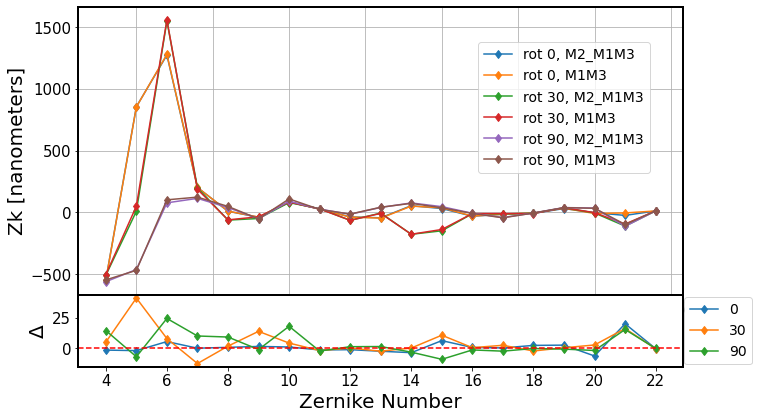

In [49]:
fig = plt.figure(figsize=(14, 5))

####################################
### left - plot the fit results  ###
#################################### 

#add_axes([xmin,ymin,dx,dy]) 
ymin=0.2
ax1 = fig.add_axes([0,ymin,0.6,0.8])  

#add_axes([xmin,ymin,dx,dy]) 
ax2 = fig.add_axes([0,0,0.6,ymin])

for rot in zkRaws.keys():
    
    for pert in zkRaws[rot].keys():
        zkRaw = zkRaws[rot][pert]
        
        for i in range(len(zkRaw)):
            ax1.plot(np.arange(4, 23),
                     1000*zkRaw[i], 
                     '-d', 
                     label=f'rot {rot}, {pert}'
                    )
    diff = zkRaws[rot]['M1M3'][0] - zkRaws[rot]['M2_M1M3'][0] 
    ax2.plot(np.arange(4, 23), 
                1000*diff, 
                '-d', 
                label=f'{rot}')
    
    
#ax1.set_xlabel('Zernike Number',) 
ax1.set_ylabel('Zk [nanometers]', )
ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.65, 0.65])
#ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()

ax2.set_xlabel('Zernike Number',) 
ax2.legend(fontsize=14, loc='center left', bbox_to_anchor=[.99, 0.5])
ax2.set_ylabel(r'$\Delta$')
ax2.set_xticks(np.arange(4,23)[::2])
ax2.axhline(0,ls='--',c='r')

The diff shows that there is indeed very little contribution from M2.  Given that , I don't see what I had expected from Zks.

In [19]:
diffs = {}
for rot in [0,30,90]:
    diffs[rot] = zkRaws[rot]['M1M3'] - zkRaws[rot]['M2_M1M3']
    

In [56]:
def compare_squares_ortho_zk(zkRaws, pert):
    ''' We would expect that orthogonal zks added in quadrature would remain constant under rotation,
    with eg. zk_x ---> zk_y , and vivce versa,
    so that zk_x**2. + zk_y **2.  = const.
    
    '''
    Nstart=4
    print(f'pert is {pert}')
    print('\n primary astigmatism')
    for rot in zkRaws.keys():
        zkRaw = zkRaws[rot][pert][0]
        print(rot, 'zk5**2+zk6**2=',zkRaw[5-Nstart]**2.0+zkRaw[6-Nstart]**2.0)

    print('\n primary coma ')
    Nstart=4
    for rot in zkRaws.keys():
        zkRaw = zkRaws[rot][pert][0]
        print(rot, 'zk7**2+zk8**2=',zkRaw[7-Nstart]**2.0+zkRaw[8-Nstart]**2.0)

    print('\n trefoil  9,10 ')
    for rot in zkRaws.keys():
        zkRaw = zkRaws[rot][pert][0]
        print('rot ', rot, 'zk9**2+zk10**2=',zkRaw[9-Nstart]**2.0+zkRaw[10-Nstart]**2.0)

    print('\n secondary astigmatism zk12-13')
    for rot in zkRaws.keys():
        zkRaw = zkRaws[rot][pert][0]
        print('rot ', rot, 'zk12**2+zk13**2=',zkRaw[12-Nstart]**2.0+zkRaw[13-Nstart]**2.0)

    print('\n quadrafoil zk14-15')
    for rot in zkRaws.keys():
        zkRaw = zkRaws[rot][pert][0]
        print('rot ', rot, 'zk14**2+zk15**2=',zkRaw[14-Nstart]**2.0+zkRaw[15-Nstart]**2.0)
        

In [59]:
compare_squares_ortho_zk(zkRaws, 'M2_M1M3')


pert is M2_M1M3

 primary astigmatism
0 zk5**2+zk6**2= 2.355095264778936
30 zk5**2+zk6**2= 2.4042893076362084
90 zk5**2+zk6**2= 0.2194074115507694

 primary coma 
0 zk7**2+zk8**2= 0.040799022979641573
30 zk7**2+zk8**2= 0.043676811743358836
90 zk7**2+zk8**2= 0.014523925265009221

 trefoil  9,10 
rot  0 zk9**2+zk10**2= 0.0086164605975037
rot  30 zk9**2+zk10**2= 0.00878829454587453
rot  90 zk9**2+zk10**2= 0.010969185357269541

 secondary astigmatism zk12-13
rot  0 zk12**2+zk13**2= 0.003217143169167191
rot  30 zk12**2+zk13**2= 0.004107545901589935
rot  90 zk12**2+zk13**2= 0.0018599029037186705

 quadrafoil zk14-15
rot  0 zk14**2+zk15**2= 0.00397740055794563
rot  30 zk14**2+zk15**2= 0.05338734548362414
rot  90 zk14**2+zk15**2= 0.008100732016136715


The only difference between `rot_0` and `rot_0_m1m3` is the turning off of `M1` subsystem via `addM2=False`. Thus the only difference between the `cmd` files is the M2 (`izenike 1 NN` perturbations):
    
        diff rot_0/iter0/pert/pert.cmd rot_0_m1m3/iter0/pert/pert.cmd 
    

gives

    < surfacemap 0 /project/scichris/aos/rotation_DM-34424/rot_0/iter0/pert/M1res.txt 1 
    ---
    > surfacemap 0 /project/scichris/aos/rotation_DM-34424/rot_0_m1m3/iter0/pert/M1res.txt 1 
    58c58
    < surfacemap 2 /project/scichris/aos/rotation_DM-34424/rot_0/iter0/pert/M3res.txt 1 
    ---
    > surfacemap 2 /project/scichris/aos/rotation_DM-34424/rot_0_m1m3/iter0/pert/M3res.txt 1 
    60,88d59
    < izernike 1 0 -1.2677738516170782e-06 
    < izernike 1 1 6.163160384342962e-11 
    < izernike 1 2 3.0227889640284744e-07 
    < izernike 1 3 3.829268057836285e-06 
    < izernike 1 4 8.20810966297251e-12 
    < izernike 1 5 -9.910364823090016e-10 
    < izernike 1 6 -1.0492107146969168e-09 
    < izernike 1 7 -2.5339599807250053e-12 
    < izernike 1 8 -3.704269957497421e-08 
    < izernike 1 9 9.120275227184589e-13 
    < izernike 1 10 -2.0227105393722544e-07 
    < izernike 1 11 -3.557023046106263e-11 
    < izernike 1 12 4.276062002451587e-12 
    < izernike 1 13 -3.402538352718213e-09 
    < izernike 1 14 -1.3457585538081258e-12 
    < izernike 1 15 1.5374575590667608e-10 
    < izernike 1 16 5.271476325493202e-07 
    < izernike 1 17 2.742972544089138e-12 
    < izernike 1 18 -5.044764684924233e-08 
    < izernike 1 19 -4.9834655576298325e-11 
    < izernike 1 20 -1.3028826031321646e-06 
    < izernike 1 21 6.099520665562994e-07 
    < izernike 1 22 1.2586766534921413e-11 
    < izernike 1 23 5.227274963663541e-10 
    < izernike 1 24 -1.9668931426366124e-12 
    < izernike 1 25 -5.456541017999657e-09 
    < izernike 1 26 -8.084991661148473e-13 
    < izernike 1 27 1.170192769974301e-08 
    < surfacemap 1 /project/scichris/aos/rotation_DM-34424/rot_0/iter0/pert/M2res.txt 1 
    
showing that these are only in `rot_0`, but not in `rot_0_m1m3`. 

Similarly `rot_30` vs `rot_30_m1m3`, via 
    
    diff rot_30/iter0/pert/pert.cmd rot_30_m1m3/iter0/pert/pert.cmd 
    
//( Initially  `rot_90_m1m3` was run with `30` , so I renamed it as `rot_30_m1m3_again`, doing a diff
 
    diff rot_30_m1m3/iter0/pert/pert.cmd  rot_30_m1m3_again/iter0/pert/pert.cmd  
    
shows it's bitwise identical, which also confirms the repeatability of "random" perturbations, sice the seed is the same for these simulations).
    
    diff rot_90/iter0/pert/pert.cmd rot_90_m1m3/iter0/pert/pert.cmd 
//